# EDA species imbalance

In [1]:
%load_ext autoreload
%autoreload 2
# %cd '/home/afischer/snakeclef-2024'

In [2]:
from snakeclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/02 02:47:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/02 02:47:25 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-snakeclef-2024/data"
train = "parquet_files/SnakeCLEF2023-train-small_size"

# Define the GCS path to the embedding files
train_gcs_path = f"{gcs_path}/{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data
train_df.show(n=3, truncate=50)

+--------------------------------------+--------------------------------------------------+------------------------+----+--------------------+-------------+--------------------------------------------------+--------------+-------+----+--------+------+
|                            image_path|                                              path|             folder_name|year|       binomial_name|    file_name|                                              data|observation_id|endemic|code|class_id|subset|
+--------------------------------------+--------------------------------------------------+------------------------+----+--------------------+-------------+--------------------------------------------------+--------------+-------+----+--------+------+
|1993/Phrynonax_polylepis/102870166.jpg|/SnakeCLEF2023-small_size/1993/Phrynonax_polyle...|SnakeCLEF2023-small_size|1993| Phrynonax_polylepis|102870166.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 0...|      64030606|  false|  EC|    1287|

In [4]:
from pyspark.sql import functions as F

# Transformation
grouped_train_df = (
    train_df.groupBy(["binomial_name", "observation_id"])
    .agg(F.count("observation_id").alias("n"))
    .orderBy(F.col("n").desc())
)

# Action
grouped_train_df.show()

+--------------------+--------------+---+
|       binomial_name|observation_id|  n|
+--------------------+--------------+---+
|Bothriechis_schle...|       5156122| 71|
|    Clelia_scytalina|      86508209| 44|
|Hierophis_viridif...|      59455956| 38|
|Trimeresurus_pope...|      59124548| 36|
|Gloydius_intermedius|      32829325| 30|
|  Porthidium_nasutum|       5152559| 30|
|    Corallus_batesii|     127314204| 27|
|Bothriechis_schle...|       5152574| 24|
|Trimorphodon_lyro...|     111941207| 21|
|   Imantodes_cenchoa|     143545669| 20|
| Rhabdophis_tigrinus|     126460414| 20|
|  Epicrates_cenchria|     140826380| 20|
|Chironius_grandis...|       5152594| 20|
|     Ninia_teresitae|     121839449| 20|
|  Corallus_blombergi|       5156125| 20|
|Sibynophis_chinensis|       4639353| 20|
| Gloydius_brevicauda|     123481958| 20|
|      Eryx_whitakeri|      67134671| 19|
|     Sibon_sanniolus|       7601657| 19|
| Chironius_scurrulus|      39117085| 19|
+--------------------+------------

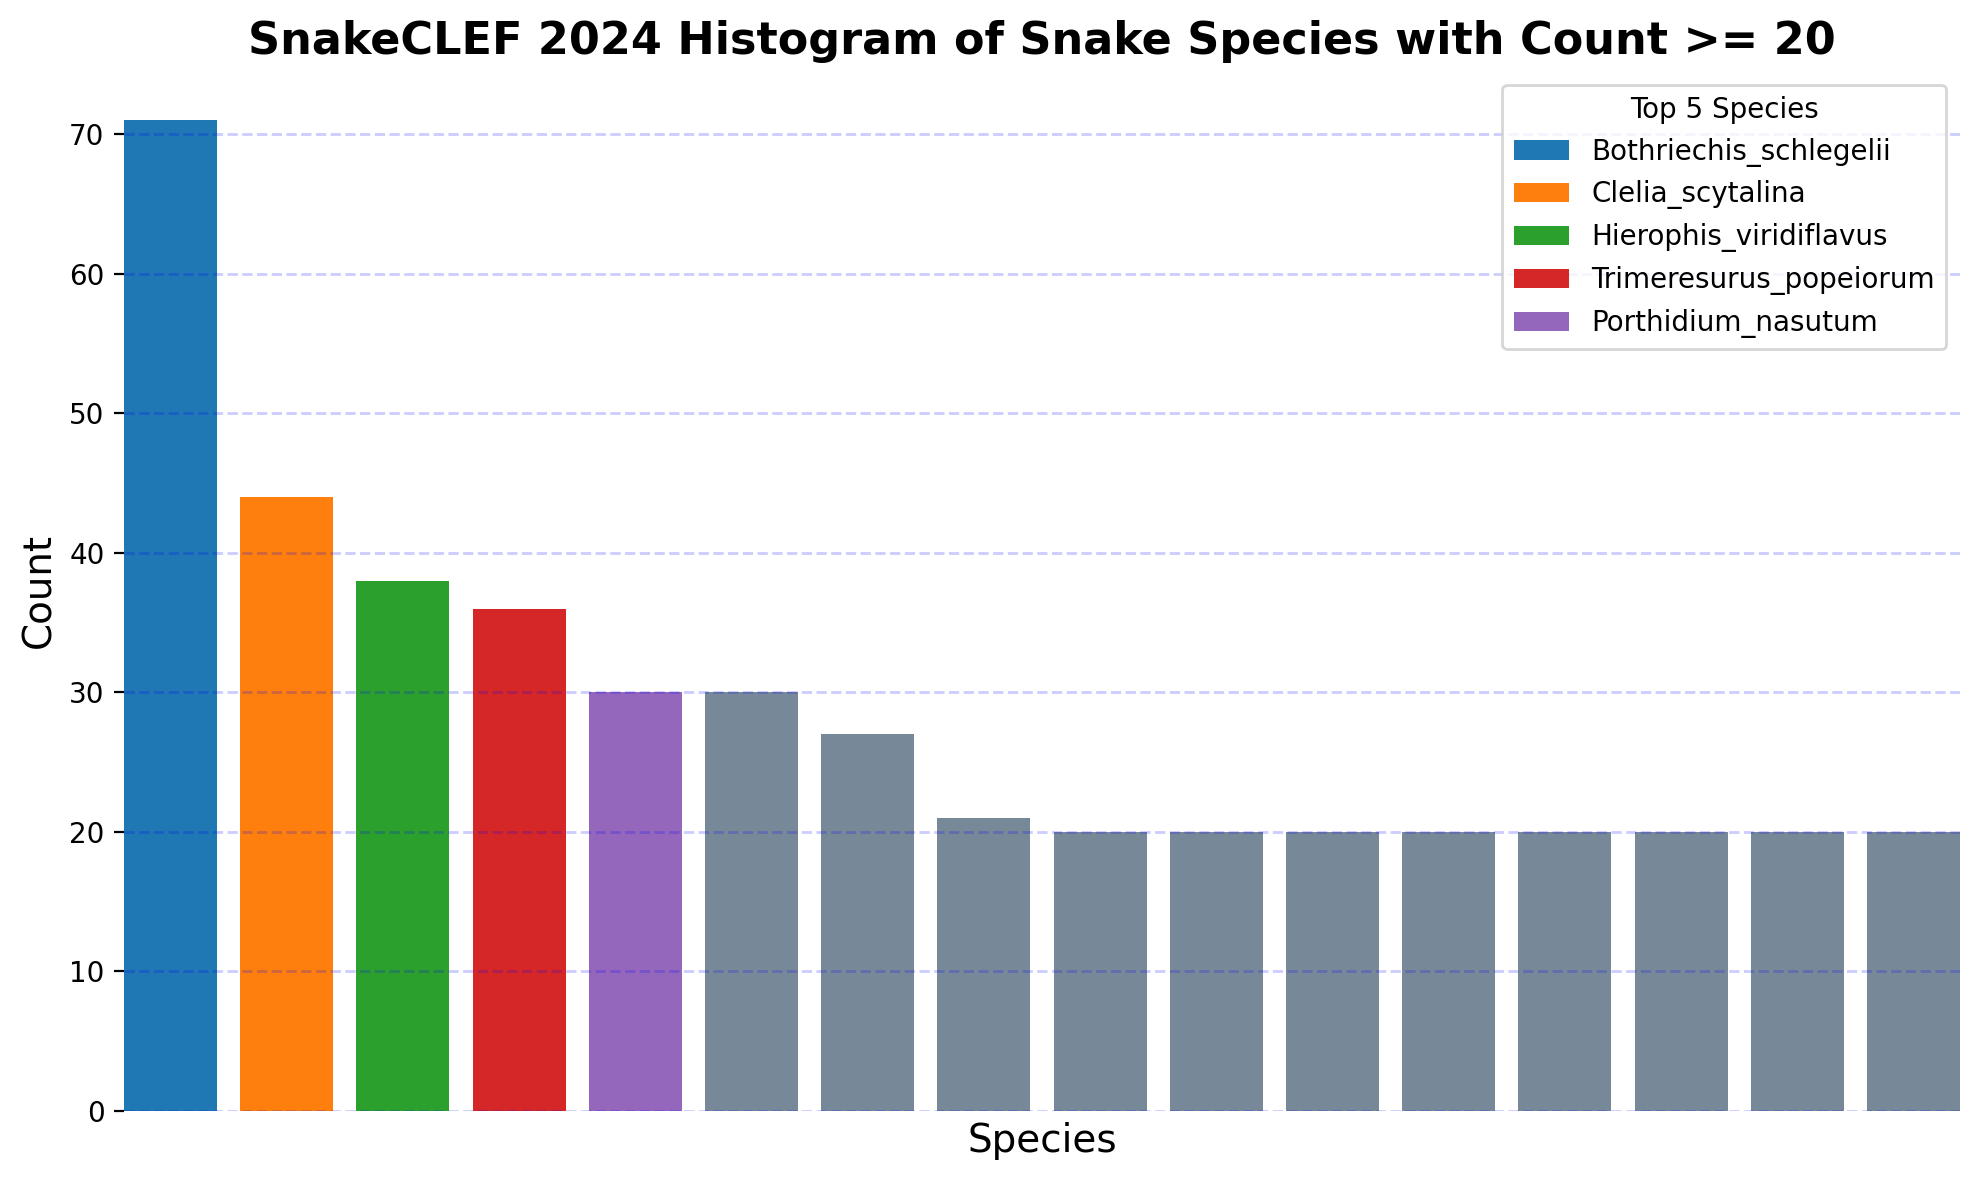

In [5]:
from snakeclef.plotting import plot_species_histogram

# Plot species
plot_species_histogram(df=grouped_train_df, species_count=20)

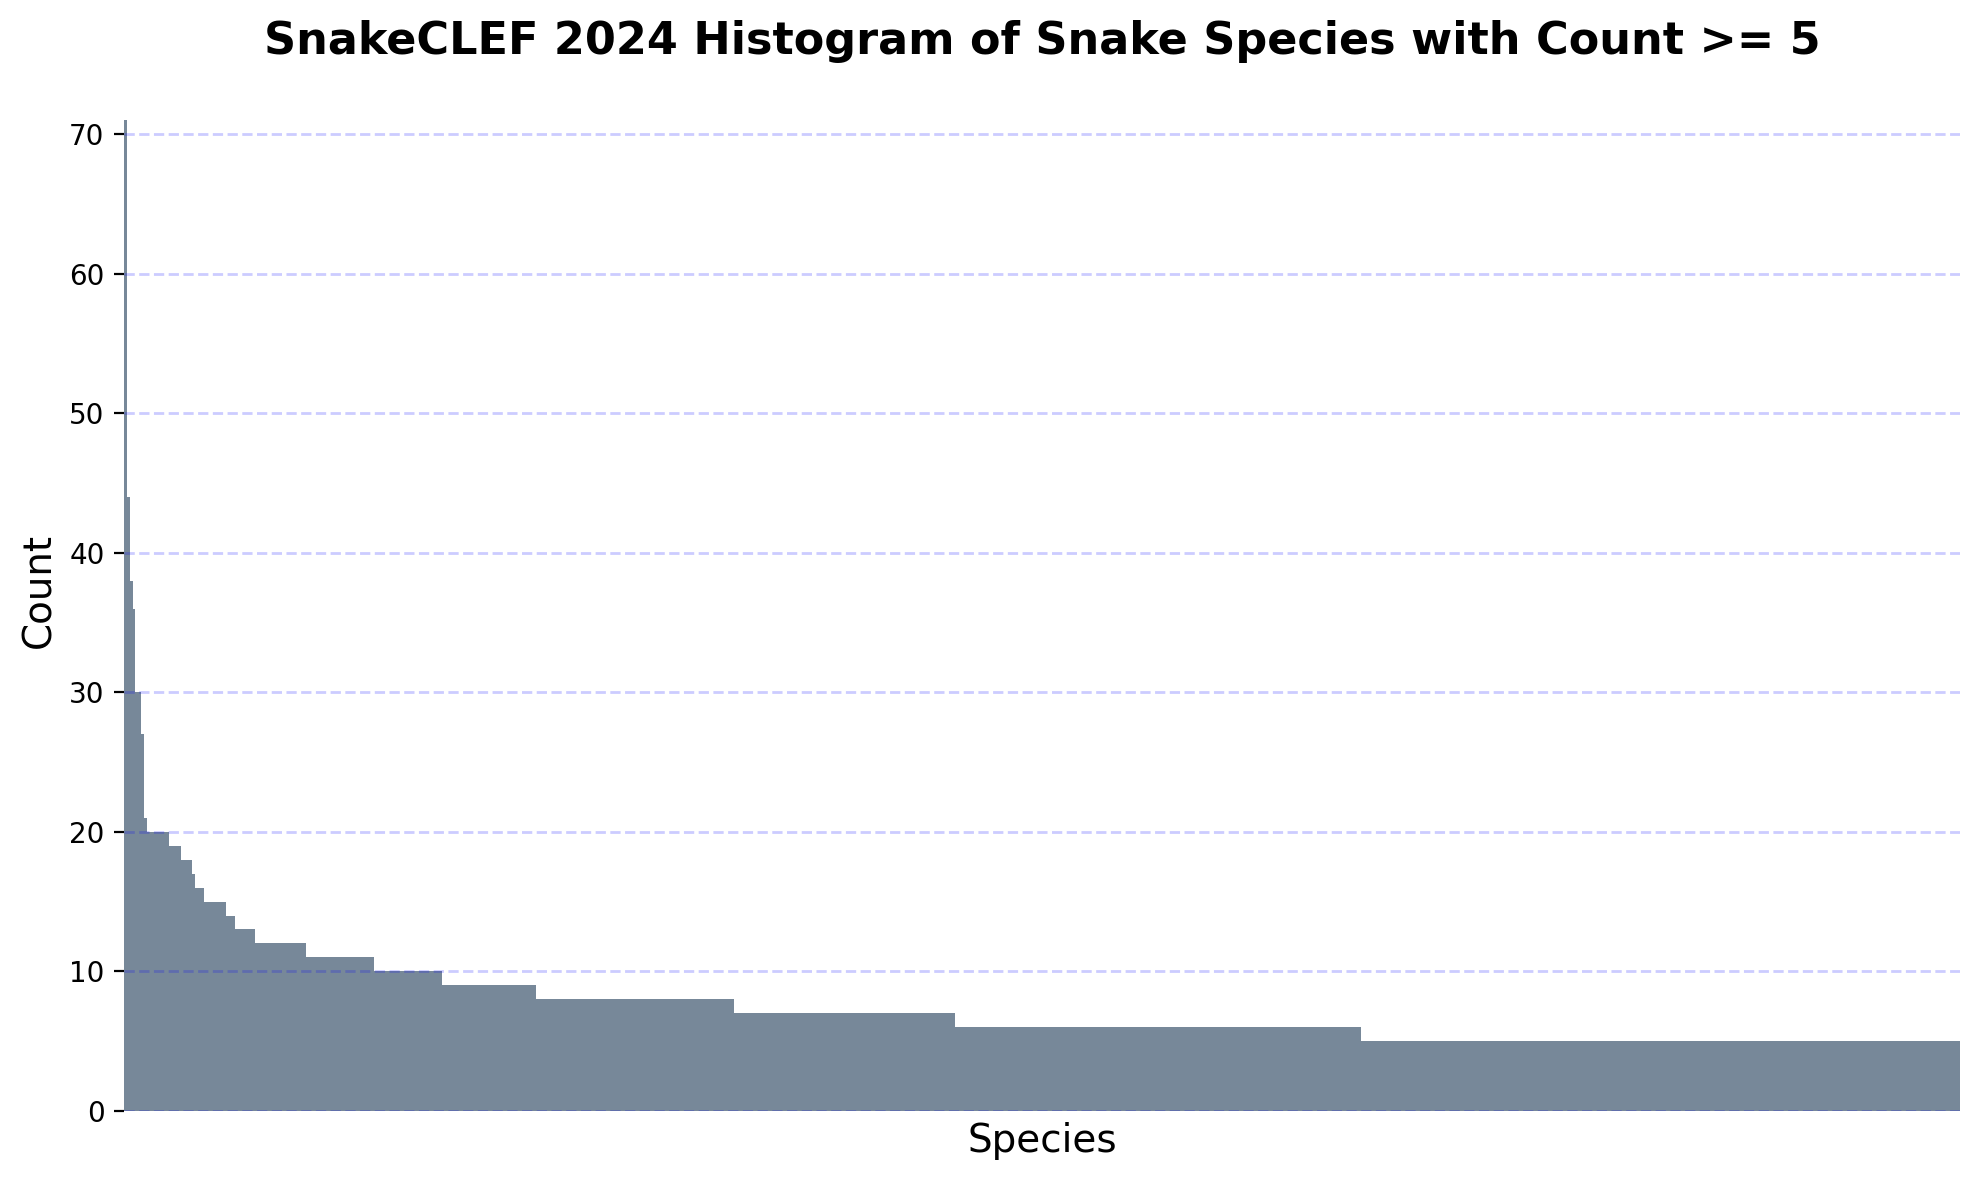

In [6]:
# Plot species with count >= 100
plot_species_histogram(df=grouped_train_df, species_count=5, bar_width=1)

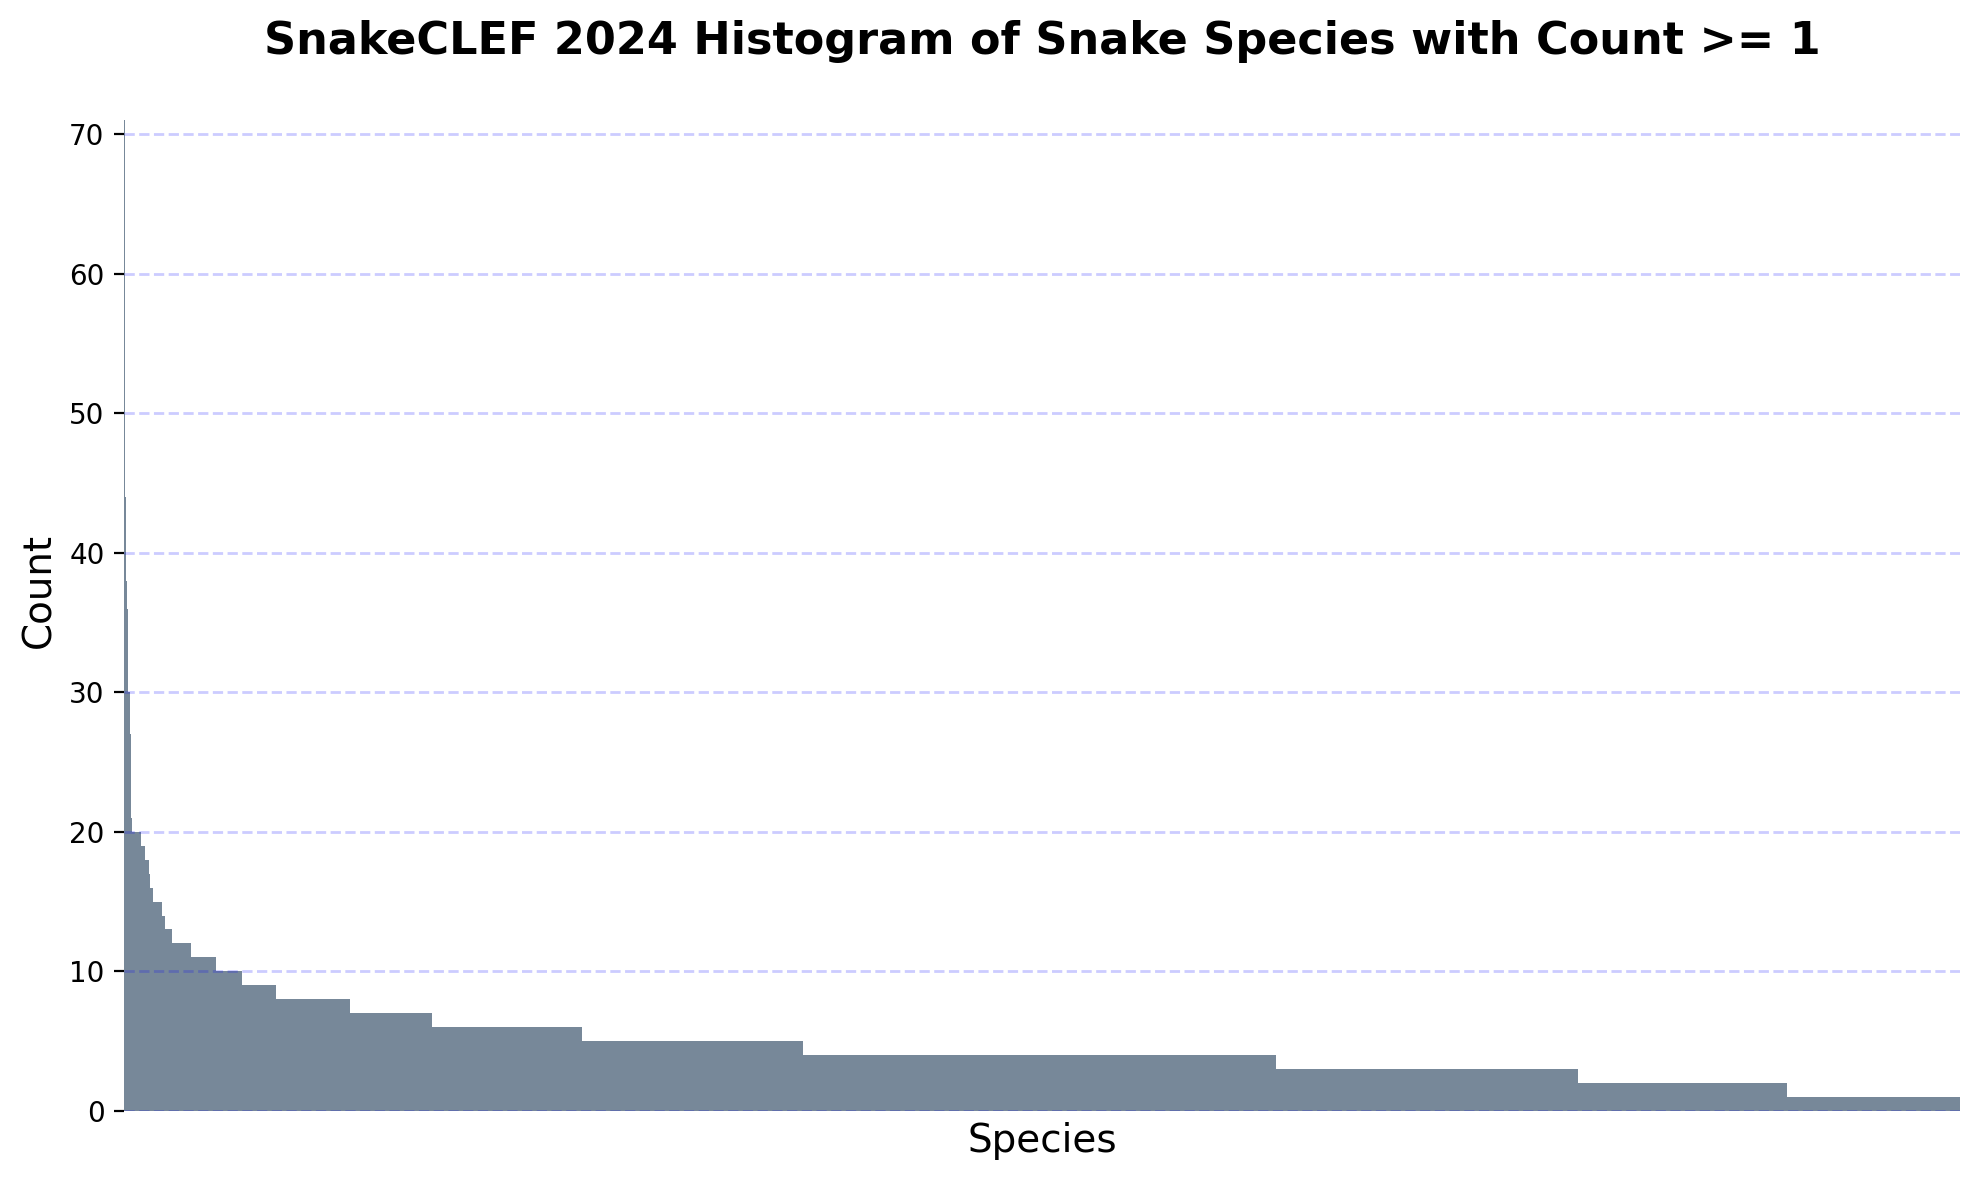

In [7]:
# Plot species with count >= 100
plot_species_histogram(df=grouped_train_df, species_count=1, bar_width=1)

In [13]:
from pyspark.sql import functions as F

sample_col = "class_id"
species_image_count = 1

# Read the Parquet file into a DataFrame
# df = spark.read.parquet('gs://dsgt-clef-snakeclef-2024/data/process/training_small_v1/dino_cls_token/data').cache()
df = spark.read.parquet(
    "gs://dsgt-clef-snakeclef-2024/data/process/training_small_v2/dino/data"
)

# Aggregate and filter species based on image count
grouped_df = (
    df.groupBy(sample_col)
    .agg(F.count(sample_col).alias("n"))
    .filter(F.col("n") >= species_image_count)
    .orderBy(F.col("n").desc(), F.col(sample_col))
    .withColumn("index", F.monotonically_increasing_id())
).drop("n")

# Use broadcast join to optimize smaller DataFrame joining
filtered_df = df.join(F.broadcast(grouped_df), sample_col, "inner")
filtered_df.show(n=5, truncate=50)

+--------+--------------------------------------------------+--------------------------------------------------+-----+
|class_id|                                              path|                                    dino_embedding|index|
+--------+--------------------------------------------------+--------------------------------------------------+-----+
|    1209|/SnakeCLEF2023-small_size/2021/Oxybelis_microph...|[-1.6648594, 0.8047742, -0.68645185, 0.29065993...|  363|
|    1334|/SnakeCLEF2023-small_size/2022/Psammodynastes_p...|[-2.4852982, -2.5238392, 0.48312128, -0.3719430...|    6|
|    1516|/SnakeCLEF2023-small_size/2020/Simoselaps_berth...|[-3.0333211, 1.7889098, -0.94739765, 0.2766313,...|  552|
|    1734|/SnakeCLEF2023-small_size/2020/Vipera_ammodytes...|[-1.5610416, 0.57020336, 3.8366265, -0.78607506...|   15|
|    1780|/SnakeCLEF2023-small_size/2019/Zamenis_longissi...|[-3.1928704, 1.7653477, 0.7510829, 0.9198719, -...|    5|
+--------+--------------------------------------

In [10]:
df.show(n=5, truncate=50)

+--------------------------------------------------+--------+--------------------------------------------------+
|                                              path|class_id|                                    dino_embedding|
+--------------------------------------------------+--------+--------------------------------------------------+
|/SnakeCLEF2023-small_size/2021/Oxybelis_microph...|    1209|[-1.6648594, 0.8047742, -0.68645185, 0.29065993...|
|/SnakeCLEF2023-small_size/2022/Psammodynastes_p...|    1334|[-2.4852982, -2.5238392, 0.48312128, -0.3719430...|
|/SnakeCLEF2023-small_size/2020/Simoselaps_berth...|    1516|[-3.0333211, 1.7889098, -0.94739765, 0.2766313,...|
|/SnakeCLEF2023-small_size/2020/Vipera_ammodytes...|    1734|[-1.5610416, 0.57020336, 3.8366265, -0.78607506...|
|/SnakeCLEF2023-small_size/2019/Zamenis_longissi...|    1780|[-3.1928704, 1.7653477, 0.7510829, 0.9198719, -...|
+--------------------------------------------------+--------+-----------------------------------

In [11]:
filtered_df.printSchema()

root
 |-- class_id: integer (nullable = true)
 |-- path: string (nullable = true)
 |-- dino_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- index: long (nullable = false)



In [ ]:
filtered_df.sort(F.col("index").desc()).show(n=5, truncate=50)
grouped_df.sort(F.col("index").desc()).show(n=5, truncate=50)

print("Unique index values:", df.select("observation_id").distinct().count())
print(
    "Unique index values train_df:",
    train_df.select("observation_id").distinct().count(),
)